In [3]:
# %load_ext autoreload
# %autoreload 2
import sys, math, time, torch, logging, json, dill, datetime, netron
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
from dqn_agent import DQNAgent, ReplayMemory, device
from double_dqn_agent import DoubleDQNAgent
from prioritized_replay_dqn_agent import PrioritizedReplayDQNAgent, PrioritizedReplayMemory
from dueling_dqn_agent import DuelingDQNAgent


# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

torch.cuda.empty_cache()
log_file_path = 'output.log'
result_file_path = 'result.json'
algorithm = 'DQN'
# ['DQN','Double_DQN', 'Prioritized_Experience_Replay', 'Dueling_DQN']

logger = logging.getLogger('p1_navigation_pixels')
while logger.handlers:
    logger.removeHandler(logger.handlers[0])
logger.propagate = False

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

sh = logging.StreamHandler(sys.stdout)
sh.setFormatter(formatter)
sh.setLevel(logging.DEBUG)

fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.INFO)

logger.addHandler(sh)
logger.addHandler(fh)
logger.setLevel(logging.DEBUG)


logger.info('CUDA version: %s, CUDA enabled: %s' % (torch.version.cuda, torch.backends.cudnn.enabled))

The current device is cuda:0
2021-03-01 20:55:26,549 INFO CUDA version: 11.0, CUDA enabled: True


In [4]:
env = UnityEnvironment(file_name='VisualBanana_Windows_x86_64/Banana.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
logger.debug('Number of agents: %i' % len(env_info.agents))

# examine the state space 
state = env_info.visual_observations[0]
logger.debug('States look like: %s' % state)
state_size = len(state)

# number of actions
action_size = brain.vector_action_space_size
logger.info('Number of agents: %i, states %i, actions: %i' % (len(env_info.agents), state_size, action_size))

if algorithm == 'DQN':
    from constants import CONSTANTS as C
    agent = DQNAgent(state_size, action_size, use_cnn_network=True)
elif algorithm == 'Double_DQN':
    from constants import CONSTANTS as C
    agent = DoubleDQNAgent(state_size, action_size, use_cnn_network=True)
elif algorithm == 'Prioritized_Experience_Replay':
    from constants import PRIORITIZED_REPLAY_CONSTANTS as C
    agent = PrioritizedReplayDQNAgent(state_size, action_size, use_cnn_network=True)
    beta = C['beta_begin']
    logger.info('It takes %f steps for beta to go from %f to %f' % ((C['beta_stable']-C['beta_begin'])/C['beta_increase'], C['beta_begin'], C['beta_stable']))
elif algorithm == 'Dueling_DQN':
    from constants import CONSTANTS as C
    agent = DuelingDQNAgent(state_size, action_size, use_cnn_network=True)
else:
    logger.warning('No algorithm specified')

logger.info(algorithm)
logger.info(json.dumps(C, indent=4))

2021-02-28 23:21:45,829 DEBUG Number of agents: 1
2021-02-28 23:21:45,837 DEBUG States look like: [[[[0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   ...
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]]

  [[0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   ...
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]]

  [[0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   ...
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]
   [0.83921569 0.7254902  0.59215686]]

  ...

  [[0.39215686 0.34117647 0.2745098 ]
   [0.39215686 0.34117647 0.2745098 ]
   [0.39215686 0.34117647 0.2745098 ]
   ...
   [0.21568627 0.17647059 0.51372549]
   [0.18039216 0.14901961

# Initialize training in two ways

In [4]:
# initialize from scratch
episode_score_hist = []
total_score = 0
step = 0
epsilon = C['epsilon_begin']
logger.info('It takes %f steps for epsilon to go from %f to %f' % (math.log(C['epsilon_stable']/C['epsilon_begin'], C['epsilon_decay']), C['epsilon_begin'], C['epsilon_stable']))

# initialize from saved file for continue training
# checkpoint = torch.load('save/pixel_DQN_20210210_092030.model')
# with open('save/pixel_agent_memory_DQN_20210210_092030.data', 'rb') as input:
#     agent_memory = dill.load(input)
    
# agent.network.load_state_dict(checkpoint['network_state_dict'])
# agent.target_network.load_state_dict(checkpoint['target_network_state_dict'])
# agent.replay_memory = agent_memory
# episode_score_hist = checkpoint['episode_score_hist']
# total_score = checkpoint['total_score']
# step = checkpoint['step']
# epsilon = checkpoint['epsilon']
# start_episode = len(episode_score_hist)
# del checkpoint, agent_memory
# logger.info('Starting episode: %i, Starting epsilon: %.2f, Starting memory length %i' % (start_episode, epsilon, len(agent.replay_memory.memory)))

2021-02-13 19:10:58,114 INFO It takes 6000.000000 steps for epsilon to go from 1.000000 to 0.010000


# Training

In [ ]:
start_time = time.time()
start_episode = len(episode_score_hist)
logger.info('Start episode: %i' % start_episode)
for i in range(start_episode, start_episode + C['num_episodes'] + 1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the env at each episode
    state = agent.preprocessing(env_info.visual_observations[0])
    done = False
    episode_score = 0                                  # initialize the score
    while not done:
        if algorithm == 'Prioritized_Experience_Replay':
            action = agent.action(state, epsilon=epsilon, beta=beta)          # select an action
            beta = min(beta+C['beta_increase'], C['beta_stable'])
        else:
            action = agent.action(state, epsilon=epsilon)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = agent.preprocessing(env_info.visual_observations[0])   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.replay_memory.add(state, action, reward, next_state, done)
        step += 1
#         logger.info('step, action, reward:%i, %i, %i' % (step, action, reward))
        episode_score += reward                        # update the score
        state = next_state                             # roll over the state to next time step
    total_score += episode_score
    episode_score_hist.append(episode_score)
    epsilon = max(epsilon*C['epsilon_decay'], C['epsilon_stable'])
    if i % 100 == 0:
        logger.info('For episode %i, the average score is %.2f, episode history %s' % (i, total_score/100, episode_score_hist[-100:]))
        total_score = 0
logger.info('The training completes in %f mins' % ((time.time() - start_time)/60))

In [ ]:
current_time = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
plt.figure(figsize=(15, 10))
plt.plot(episode_score_hist)
plt.title('Episode Score with %s' % algorithm)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.savefig('episode_score_with_%s_visual_2.png' % algorithm, bbox_inches='tight')

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = torch.tensor(env_info.visual_observations[0]).to(device).transpose(0, 3).float().squeeze().unsqueeze(0)            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.action(state, epsilon=epsilon, beta=0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = torch.tensor(env_info.visual_observations[0]).to(device).transpose(0, 3).float().squeeze().unsqueeze(0)   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
logger.info("Score: {}".format(score))

In [ ]:
# save the model and results
checkpoint = {
    'constants': C,
    'step': step,
    'episode_score_hist': episode_score_hist,
    'total_score': total_score,
    'epsilon': epsilon,
    'network_state_dict': agent.network.state_dict(),
    'target_network_state_dict': agent.target_network.state_dict()
}

torch.save(checkpoint, 'save/pixel_%s_%s.model' % (algorithm, current_time))
with open('save/pixel_agent_memory_%s_%s.data' % (algorithm, current_time), 'wb') as output:
    dill.dump(agent.replay_memory, output)


# Load model weights from the checkpoint

In [4]:
if algorithm == 'DQN':
    from constants import CONSTANTS as C
    agent_demo = DQNAgent(state_size, action_size, use_cnn_network=True)
elif algorithm == 'Double_DQN':
    from constants import CONSTANTS as C
    agent_demo = DoubleDQNAgent(state_size, action_size, use_cnn_network=True)
elif algorithm == 'Prioritized_Experience_Replay':
    from constants import PRIORITIZED_REPLAY_CONSTANTS as C
    agent_demo = PrioritizedReplayDQNAgent(state_size, action_size, use_cnn_network=True)
    beta = C['beta_begin']
    logger.info('It takes %f steps for beta to go from %f to %f' % ((C['beta_stable']-C['beta_begin'])/C['beta_increase'], C['beta_begin'], C['beta_stable']))
elif algorithm == 'Dueling_DQN':
    from constants import CONSTANTS as C
    agent_demo = DuelingDQNAgent(state_size, action_size, use_cnn_network=True)
else:
    logger.warning('No algorithm specified')

with open('pixel_DQN_20210210_092030.model', 'rb') as input:
    checkpoint = dill.load(input)
   
agent_demo.network.load_state_dict(checkpoint['network_state_dict'])
agent_demo.target_network.load_state_dict(checkpoint['target_network_state_dict'])
episode_score_hist = checkpoint['episode_score_hist']
del checkpoint
onnx_path = 'save/onnx_model_name.onnx'
torch.onnx.export(agent_demo.network, agent_demo.preprocessing(env_info.visual_observations[0]), onnx_path) 
netron.start(onnx_path)


NameError: name 'state_size' is not defined

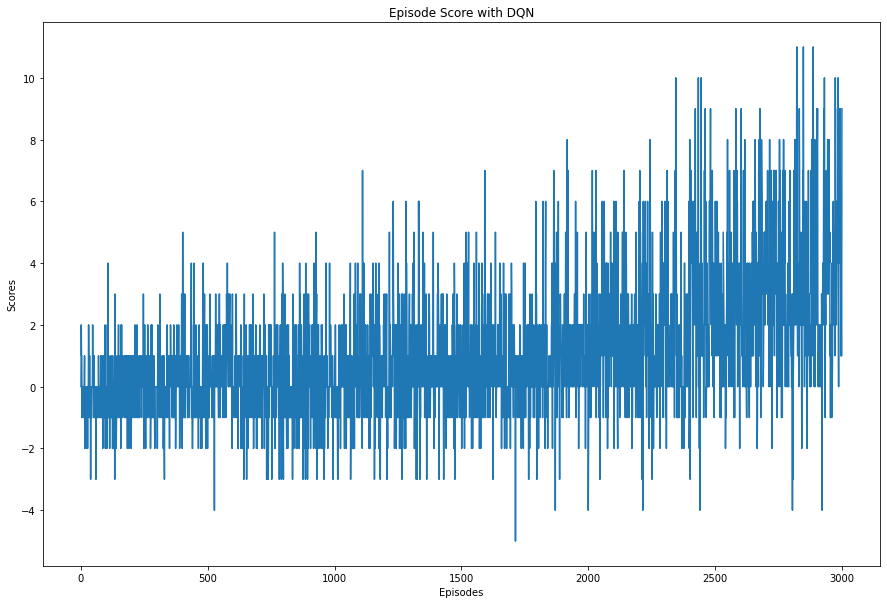

In [15]:
current_time = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
plt.figure(figsize=(15, 10))
plt.plot(episode_score_hist)
plt.title('Episode Score with %s' % algorithm)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.savefig('plot/episode_score_pixel_%s_%s.png' % (algorithm, current_time), bbox_inches='tight')

In [20]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = agent_demo.preprocessing(env_info.visual_observations[0])            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent_demo.action(state, epsilon=0.1, beta=0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = agent_demo.preprocessing(env_info.visual_observations[0])   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

logger.info("Score: {}".format(score))

2021-03-01 00:11:14,478 INFO Score: 0.0


In [ ]:
# env.close()